# Planar 2D-2D Geometry (Projective Geometry)

Planar Homography Estimation
- Unknown: <font color='red'>Planar homograph (8 DoF)</font>
- Given: Point correspondences ($x_1$, $x'_1$), ..., ($x_n$, $x'_n$).
- Constraints: $n$ projective transformations $x'_i = Hx_i$
- Solutions ($n\ge4$)-> 4-point algorithm
  * More simplied transformations need less number of minimal correspondences. For instance, Affine ($n\ge3$), similarity ($n\ge2$), Euclidean ($n\ge2$).

In [1]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## General 2D-2D Geometry (Epipolar Geometry)

### Essential Matrix Estimation
* Unknown: <font color='red'>Essential matrix (5 DoF)</font>
* Given: Point correspondences on the normalized image plane ($\hat{x}_1$, $\hat{x}'_1$), ..., ($\hat{x}_n$, $\hat{x}'_n$)
* Constraints: $n$ epipolar constraints: $\hat{x}'_i E \hat{x}_i=0$.
* Solutions: 5-point algorithm

### Fundamental Matrix Estimation
* Unknown: <font color='red'>Fundamental matrix (7 DoF)</font>
* Given: Point correspondences on the image plane ($x_1$, $x'_1$), ..., ($x_n$, $x'_n$)
* Constraints: $n$ epipolar constraints: $x'_i F x_i=0$.
* Solutions: 7/8-point algorithm

In the first example, we estimate the Fundamental matrix using OpenCV's `findFundamentalMat` and our self-implemented `estFundmentalMat` using point correspondences established from two images. We plot the point correspondences and epipolar lines in each image.

In [39]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1, img2

In [31]:
def plot_epipolar_lines(F, image1, pts1, image2, pts2):
  # Find epilines corresponding to points in right image (second image) and
  # drawing its lines on left image
  lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
  lines1 = lines1.reshape(-1, 3)
  img3, _ = drawlines(image1, image2, lines1, pts1, pts2)

  # Find epilines corresponding to points in left image (first image) and
  # drawing its lines on right image
  lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
  lines2 = lines2.reshape(-1, 3)
  img4, _ = drawlines(image2, image1, lines2, pts2, pts1)

  plt.subplot(121),plt.imshow(img3)
  plt.subplot(122),plt.imshow(img4)
  plt.show()

In [57]:
# Read two images.
image_name1, image_name2 = 'B21.jpg', 'B22.jpg'
image1 = cv2.imread(image_name1, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(image_name2, cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
key1, desc1 = sift.detectAndCompute(image1, None)
key2, desc2 = sift.detectAndCompute(image2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(desc1, desc2, k=2)

pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts1.append(key1[m.queryIdx].pt)
        pts2.append(key2[m.trainIdx].pt)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

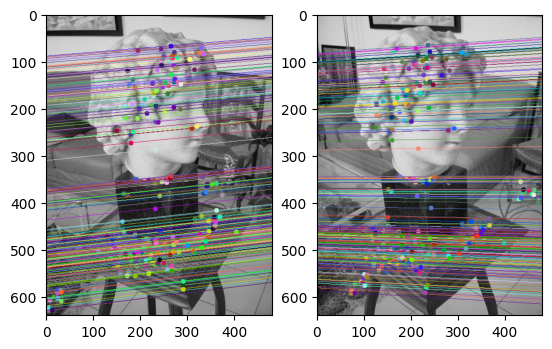

In [62]:
# Fundamental Matrix Estimation using OpenCV method
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

plot_epipolar_lines(F, image1, pts1, image2, pts2)

In [60]:
# Estimate Fundamental Matrix using 8-point algorithm.
def estFundamentalMat(pts1, pts2, normalized=True):
  if len(pts1) == len(pts2):
      # Make homogeneous coordiates if necessary
      if pts1.shape[1] == 2:
          pts1 = np.hstack((pts1, np.ones((len(pts1), 1), dtype=pts1.dtype)))
      if pts2.shape[1] == 2:
          pts2 = np.hstack((pts2, np.ones((len(pts2), 1), dtype=pts2.dtype)))

  # Normalize points, otherwise ill-conditioned.
  if normalized:
    std1, std2 = pts1.std(0), pts2.std(0)
    std1[std1<1e-6] = 1e-6 # avoid divide by zero
    std2[std2<1e-6] = 1e-6
    std1_rcp, std2_rcp = 2./std1, 2./std2
    mean1, mean2 = pts1.mean(0), pts2.mean(0)
    T1 = np.array([[std1_rcp[0], 0.         , -std1_rcp[0]*mean1[0]],
                   [0.         , std1_rcp[1], -std1_rcp[1]*mean1[1]],
                   [0.         , 0.         , 1.]])
    T2 = np.array([[std2_rcp[0], 0.         , -std2_rcp[0]*mean2[0]],
                   [0.         , std2_rcp[1], -std2_rcp[1]*mean2[1]],
                   [0.         , 0.         , 1.]])

    pts1 = pts1@T1.T
    pts2 = pts2@T2.T
    # print(pts1.std(0), pts2.std(0)) # should have std: sqrt(2).
    # print(pts1.mean(0), pts2.mean(0)) # should have zero mean.

  # Solve 'Ax = 0'
  A = []
  for p, q in zip(pts1, pts2):
      A.append([q[0]*p[0], q[0]*p[1], q[0]*p[2], q[1]*p[0], q[1]*p[1], q[1]*p[2], q[2]*p[0], q[2]*p[1], q[2]*p[2]])
  _, _, Vt = np.linalg.svd(A, full_matrices=True)
  x = Vt[-1]

  # Reorganize 'F' and enforce 'rank(F) = 2'
  F = x.reshape(3, -1)
  U, S, Vt = np.linalg.svd(F)
  S[-1] = 0
  F = U @ np.diag(S) @ Vt
  F = T1.T@F@T2 # De-normalize F
  return F / F[-1,-1] # Normalize the last element as 1

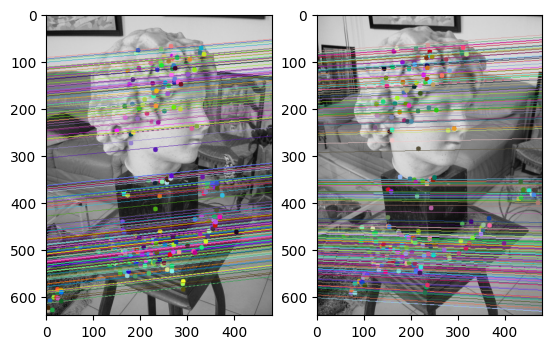

In [63]:
# Fundamental Matrix Estimation using self-implemented 8-point algorithm.
# Note: We're not using RANSAC, so using the filtered point correspondence above.
F = estFundamentalMat(pts1, pts2)

plot_epipolar_lines(F, image1, pts1, image2, pts2)

In the second example, we simulate the image formation process by projecting a 3D box into two image planes with known intrinsic and extrinsic matrices.

We can compute the Fundamental matrix from the intrinsic and extrinsic matrices as follows.

\begin{aligned}
F &= K_2^{-T} E K_1^{-1} \\
  &= K_2^{-T} |t|_× R K_1^{-1}
\end{aligned}

Where $|t|_×$ is the skew symmetric matrix of vector $t$. We can also estimate the fundamental matrix from the point correspondences from the two images. We can verify that the fundamental matrices computed using these two approaches to close to each other.

In [2]:
# read xyz file
# format Homogenous Coordinate
X = np.loadtxt("box.xyz")
X = np.hstack((X, np.ones((X.shape[0], 1)))).T
X.shape

(4, 160)

In [3]:
# image resolution
img_res = np.array([480, 640])
w, h = img_res[1], img_res[0]

# Camera Intrinsic Parameter
f, cx, cy = 1000, 320, 240

# Pixel size ranges from 1.1 microns in the smallest smartphone sensor, to 8.4 microns in a Full-Frame sensor.
px_size = 0.001

# Camera Orientation and Position
cam_ori = np.array([[0, 0, 0], [np.pi/12, -np.pi/12, 0]])
cam_pose = np.array([[0, 0, 0], [2, 2, 0]])

cam_ori, cam_pose

(array([[ 0.        ,  0.        ,  0.        ],
        [ 0.26179939, -0.26179939,  0.        ]]),
 array([[0, 0, 0],
        [2, 2, 0]]))

In [4]:
def RX(rx):
    return np.array([[1., 0, 0],
                     [0, math.cos(rx), -math.sin(rx)],
                     [0, math.sin(rx), math.cos(rx)]], dtype=np.float32)

def RY(ry):
    return np.array([[math.cos(ry), 0, math.sin(ry)],
                     [0, 1, 0],
                     [-math.sin(ry), 0, math.cos(ry)]], dtype=np.float32)

def RZ(rz):
    return np.array([[math.cos(rz), -math.sin(rz), 0],
                     [math.sin(rz), math.cos(rz), 0],
                     [0, 0, 1]], dtype=np.float32)

# Derive the extrinsice Matrix
def extrinsic_mat(ori, pose):
  Rc = RZ(ori[2]) @ RY(ori[1]) @ RX(ori[0])
  tc = pose
  R = Rc.T
  t = -Rc.T @ tc
  return R, t

In [5]:
# Visualization related methods
def plot_data(ax, x, y, z):
  ax.scatter(x, y, z, marker='.')

def plot_camera(ax, R, t, w, h, f, scale=0.0001):
  V = np.array([[0, 0, 0, f, -w/2,  w/2, w/2, -w/2],
                [0, 0, f, 0, -h/2, -h/2, h/2,  h/2],
                [0, f, 0, 0,  f,    f,   f,    f]])
  V *= scale # px size
  V = R.T @ (V - t.reshape((3, 1)))

  ax.plot(V[0, [0, 3]], V[1, [0, 3]], zs=V[2, [0, 3]], color='r') # x-axis
  ax.plot(V[0, [0, 2]], V[1, [0, 2]], zs=V[2, [0, 2]], color='g') # y-axis
  ax.plot(V[0, [0, 1]], V[1, [0, 1]], zs=V[2, [0, 1]], color='b') # z-axis

  ax.plot(V[0, [0, 4]], V[1, [0, 4]], V[2, [0, 4]], color='k')
  ax.plot(V[0, [0, 5]], V[1, [0, 5]], V[2, [0, 5]], color='k')
  ax.plot(V[0, [0, 6]], V[1, [0, 6]], V[2, [0, 6]], color='k')
  ax.plot(V[0, [0, 7]], V[1, [0, 7]], V[2, [0, 7]], color='k')

  ax.plot(V[0, [4,5,6,7,4]], V[1, [4,5,6,7,4]], V[2, [4,5,6,7,4]], color='k')

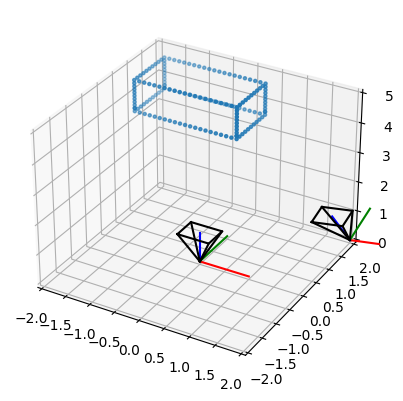

In [6]:
# Visualize the 3D box and two cameras
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(0, 5)
for ori, pose in zip(cam_ori, cam_pose):
  R, t = extrinsic_mat(ori, pose)
  plot_camera(ax, R, t, w, h, f, px_size)
plot_data(ax, X[0], X[1], X[2])
plt.show()

In [7]:
def skew_mat(t):
  return np.array([[0.   , -t[2], t[1]],
                   [t[2] , 0.   , -t[0]],
                   [-t[1], t[0] , 0]])

F matrix element-wise diff < 0.01: True


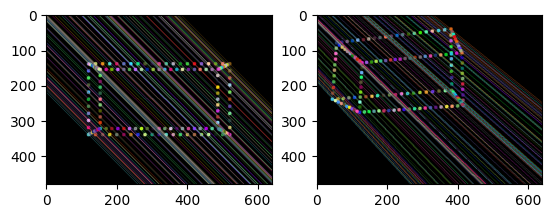

In [50]:
# Extrinsic matrix
R1, t1 = extrinsic_mat(cam_ori[0], cam_pose[0])
R2, t2 = extrinsic_mat(cam_ori[1], cam_pose[1])
Rt1 = np.hstack((R1, t1.reshape(3, 1))) # 3x4
Rt2 = np.hstack((R2, t2.reshape(3, 1))) # 3x4

# Intrinsic matrix
K = np.array([[f, 0, cx],
              [0, f, cy],
              [0, 0, 1]])

# Projection to image plane
x1 = K @ Rt1 @ X # (3,3)x(3,4)x(4,N)=(3,N)
x2 = K @ Rt2 @ X
x1 /= x1[2]
x2 /= x2[2]
x1_px = np.int32(x1[:2].T) # (Nx2)
x2_px = np.int32(x2[:2].T)

# Fundamental Matrix (from E)
# E = K2.T * F * K1 <===> F = K2^{-T} * E * K1^{-1}
F1 = np.linalg.inv(K.T) @ skew_mat(t2) @ R2 @ np.linalg.inv(K)
F1 /= F1[-1, -1]

# Fundamental Matrix (8-point)
F2, _ = cv2.findFundamentalMat(x1_px, x2_px, cv2.FM_LMEDS)
print(f'F matrix element-wise diff < 0.01: {np.allclose(F1, F2, atol=1e-2)}')

# Uncomment the following code block: verify that Fundamental Matrix works as intended.
# for x1i, x2i in zip(x1.T, x2.T):
#   print(f'x2.T*F*x1 close to 0 (<0.01): {np.allclose(x2i.reshape(1, 3) @ F1 @ x1i, 0., atol=0.01)}')

# Plot epipolar geometry
image1 = np.zeros(img_res, dtype=np.uint8)
image2 = np.zeros(img_res, dtype=np.uint8)
plot_epipolar_lines(F1, image1, x1_px, image2, x2_px)

In [179]:
# This is not a good example. Keep it here for future reference.
pts0 = np.loadtxt('image_formation0.xyz')
pts1 = np.loadtxt('image_formation1.xyz')

my_F = estFundamentalMat(pts0, pts1)
cv_F, _ = cv2.findFundamentalMat(pts0, pts1, cv2.FM_8POINT)

print('\n### My Fundamental Matrix')
print(my_F)
print('\n### OpenCV Fundamental Matrix')
print(cv_F) # Note) The result is slightly different because OpenCV considered normalization


### My Fundamental Matrix
[[ 3.21279235e-06 -3.44385929e-06  1.00838687e-02]
 [ 3.60821287e-06 -2.99830127e-06 -1.20447798e-02]
 [-1.48320672e-02  1.41297085e-02  1.00000000e+00]]

### OpenCV Fundamental Matrix
[[ 1.74112973e-05 -1.90730866e-05  6.23986061e-02]
 [ 1.82536639e-05 -1.65112875e-05 -6.94722451e-02]
 [-7.12457989e-02  7.14240132e-02  1.00000000e+00]]


### Relationship between Essential matrix and Fundamental matrix

\begin{eqnarray}
x'^\top_i F x_i &= 0 \\
\hat{x}'^\top_i K'^\top \cdot F \cdot K \hat{x}_i &= 0 \\
\hat{x}'^\top_i E \hat{x}_i &= 0
\end{eqnarray}

Thus we have the following relation between Fundamental matrix $F$ and Essential matrix $E$

\begin{equation}
E = K'^\top F K
\end{equation}

where $x_i$ is a point on the image plane whereas $\hat{x}'_i$ is a point on the normalized image plane. Thus we have
\begin{eqnarray}
x_i &= K \hat{x}_i \\
x'_i &= K' \hat{x}'_i
\end{eqnarray}

Conversely, we have
\begin{equation}
F = K'^{-\top} E K^{-1}
\end{equation}


In [51]:
# Projection to camera CS.
x1_cam = Rt1 @ X # (3,4)x(4,N)=(3,N)
x2_cam = Rt2 @ X # (3,4)x(4,N)=(3,N)
x1_norm = x1_cam / x1_cam[2]
x2_norm = x2_cam / x2_cam[2]

## Check that the projected image points are close enough.
x1_img = K@x1_norm
x2_img = K@x2_norm
print(f'image 1 points close: {np.allclose(x1, x1_img, atol=1e-3)}')
print(f'image 2 points close: {np.allclose(x2, x2_img, atol=1e-3)}')

# Essential Matrix (from R, t)
E1 = skew_mat(t2) @ R2
E1 /= E1[-1, -1]

# Essential Matrix (from F matrix)
# E = K2.T * F * K1
E2 = K.T @ F1 @ K
E2 /= E2[-1, -1]

# Essential Matrix (from point correspondence)
E3, _ = cv2.findEssentialMat(x1_px, x2_px, K, cv2.RANSAC, 0.99, 1)
E3 /= E3[-1, -1]
print(f'E1, E2 element-wise diff < 0.01: {np.allclose(E1, E2, atol=1e-2)}')
print(f'E1, E3 element-wise diff < 0.01: {np.allclose(E1, E3, atol=1e-2)}')
E1, E3

# Verify that Essential Matrix works as intended.
# x2_norm.T @ E @ x1_norm = 0
for x1i, x2i in zip(x1_norm.T, x2_norm.T):
  print(f'x2norm.T*E*x1norm close to 0: {np.allclose(x2i.reshape(1, 3) @ E1 @ x1i, 0.)}')

image 1 points close: True
image 2 points close: True
E1, E2 element-wise diff < 0.01: True
E1, E3 element-wise diff < 0.01: False
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0: True
x2norm.T*E*x1norm close to 0:

### Relative Camera Pose Estimation

TBD

In [52]:
E = skew_mat(t2) @ R2
E /= E[-1, -1]

R_est1, R_est2, t_est = cv2.decomposeEssentialMat(E)

# Depth check: select rotation giving positive Z-value in camera CS.
for R_est in (R_est1, R_est2):
  Rt_est = np.hstack((R_est, t_est))
  x = Rt_est @ X
  if np.alltrue(x[2]>0): break

# |R_est| is close to R2
print(f'Rotation matrix close: {np.allclose(R2, R_est, atol=1e-3)}')

# |t_est| is a scaled version of |t2|.
print(f'translation vec scaling: {t_est.T / t2}')

Rotation matrix close: True
translation vec scaling: [[0.3535534 0.3535534 0.3535534]]


### Scale Ambiguity

In [53]:
x1 = K @ Rt1 @ X
x2 = K @ Rt2 @ X
x1 /= x1[2]
x2 /= x2[2]
x1_px = np.int32(x1[:2].T) # (Nx2)
x2_px = np.int32(x2[:2].T)

# Fundamental Matrix (8-point)
F, _ = cv2.findFundamentalMat(x1_px, x2_px, cv2.LMEDS)

# Essential matrix
E = K.T @ F @ K

R_est1, R_est2, t_est = cv2.decomposeEssentialMat(E)
# Depth check: select rotation giving positive Z-value in camera CS.
for R_est in (R_est1, R_est2):
  Rt_est = np.hstack((R_est, t_est))
  x = Rt_est @ X
  if np.alltrue(x[2]>0): break
Rt2_est = Rt_est

# Triangulation
x1_img = np.float32(x1_px.T)
x2_img = np.float32(x2_px.T)
X_est = cv2.triangulatePoints(K@Rt1, K@Rt2_est, x1_img, x2_img)
X_est /= X_est[3]

The real scene (orange dots) and reconstructed scene (blue dots) and two-view camera geometry are plotted as below. As we can see, the reconstructed scene is a scaled version of the real scene due to scale ambiguity.

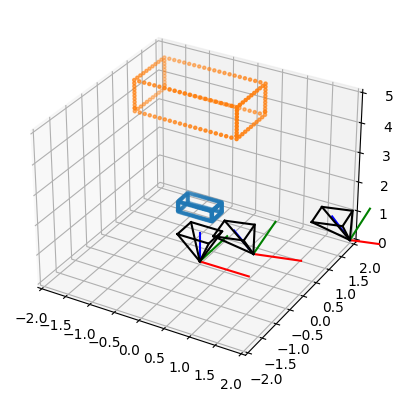

In [64]:
# Visualize the 3D box and two cameras
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(0, 5)
for Rt in (Rt1, Rt2, Rt2_est):
  R, t = Rt[:,:3], Rt[:,3]
  plot_camera(ax, R, t, w, h, f, px_size)
plot_data(ax, X_est[0], X_est[1], X_est[2])
plot_data(ax, X[0], X[1], X[2])
plt.show()

### Visual Odometry

In [ ]:
def plot_camera(R, t, w, h, f, scale=0.0001):
  V = np.array([[0, 0, 0, f, -w/2,  w/2, w/2, -w/2],
                [0, 0, f, 0, -h/2, -h/2, h/2,  h/2],
                [0, f, 0, 0,  f,    f,   f,    f]])
  V *= scale
  V = R.T @ (V - t.reshape((3, 1)))

  plt.plot(V[0, [0, 3]], V[1, [0, 3]], zs=V[2, [0, 3]], color='r') # x-axis
  plt.plot(V[0, [0, 2]], V[1, [0, 2]], zs=V[2, [0, 2]], color='g') # y-axis
  plt.plot(V[0, [0, 1]], V[1, [0, 1]], zs=V[2, [0, 1]], color='b') # z-axis

  plt.plot(V[0, [0, 4]], V[1, [0, 4]], V[2, [0, 4]], color='k')
  plt.plot(V[0, [0, 5]], V[1, [0, 5]], V[2, [0, 5]], color='k')
  plt.plot(V[0, [0, 6]], V[1, [0, 6]], V[2, [0, 6]], color='k')
  plt.plot(V[0, [0, 7]], V[1, [0, 7]], V[2, [0, 7]], color='k')

  plt.plot(V[0, [4,5,6,7,4]], V[1, [4,5,6,7,4]], V[2, [4,5,6,7,4]], color='k')

In [ ]:
from signal import raise_signal
import cv2
import numpy as np
import glob

input = "%06d.png"
f = 707.0912
c = (601.8873, 183.1104)
use_5pt = True
min_inlier_num = 100

# Open a file to write camera trajectory
# my_file = "../bin/data/vo_epipolar_v2.xyz"
# camera_trajectory = open(my_file, 'wt')
# if camera_trajectory == 0: raise Exception("Can't make file")

# Open a video and get initial image
cap = cv2.VideoCapture(input)
if cap.isOpened() == False: raise Exception("Cant read images")

_, image = cap.read()
gray_prev = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

camera_pose = np.eye(4, dtype=np.float64)

count = 1
images = [image]
camera_poses = [camera_pose]
while cap.isOpened():
  ret, image = cap.read()
  if ret == False: break
  if image.shape[2] == 3: gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  point_prev = cv2.goodFeaturesToTrack(gray_prev, 2000, 0.01, 10)

  point, status, err = cv2.calcOpticalFlowPyrLK(gray_prev, gray, point_prev, None)
  gray_prev = gray

  if use_5pt:
      E, inliner_mask = cv2.findEssentialMat(point_prev, point, f, c, cv2.FM_RANSAC, 0.99, 1)
  else:
      F, inliner_mask = cv2.findFundamentalMat(point_prev, point, cv2.FM_RANSAC, 1, 0.99)
      K = np.array([[f, 0, c[0]], [0,f,c[1]], [0,0,1]])
      E = K.T @ F @ K

  inlier_num, R, t, mask = cv2.recoverPose(E, point, point_prev)

  if inlier_num > min_inlier_num:
      T = np.eye(4)
      T[0:3, 0:3] = R * 1.0
      T[0:3,[3]] = t* 1.0
      # T[0:3, 0:3] = R.T
      # T[0:3, [3]] = R.T @ t
      camera_pose = camera_pose @ np.linalg.inv(T)
      # camera_pose = np.linalg.inv(T)

  # Show the image and write camera pose
  if image.shape[2] < 3: image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

  # for i in range(len(point_prev)):
  #     px_prev, py_prev = point_prev[i][0][0], point_prev[i][0][1]
  #     px, py = point[i][0][0], point[i][0][1]
  #     if inliner_mask[i] > 0: image = cv2.line(image, (px_prev, py_prev), (px, py), (0,0,255))
  #     else: image = cv2.line(image, (px_prev, py_prev), (px, py), (0,127,0))

  info = f"Inliers: {inlier_num} ({100*inlier_num/len(point)}), XYZ: [{camera_pose[0][2]:.3f} {camera_pose[1][2]:.3f} {camera_pose[2][2]:.3f}]"
  # camera_trajectory.write(f"{camera_pose[0][2]:.6f} {camera_pose[0][2]:.6f} {camera_pose[0][2]:.6f}\n")
  cv2.putText(image, info, (5,15), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0))
  # cv2.imshow("test", image)
  # key = cv2.waitKey(1)
  # if key == ord('q'): break

  camera_poses.append(camera_pose)

  if count % 10:
    images.append(image)
  count += 1

cap.release()
# camera_trajectory.close()

# plot images
# if not len(images): raise Exception("No images")
# ncols = 3
# nrows = math.ceil(len(images) / ncols)
# f, ax = plt.subplots(nrows, figsize=[200, 60])
# for i in range(nrows):
#   vis_image = np.hstack((images[i*ncols:(i+1)*ncols]))
#   ax[i].imshow(vis_image[:, :, (2, 1, 0)])
#   ax[i].axis('off')
# plt.show()

# plot camera poses
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(-90, 0)
for i in range(len(camera_poses)):
  plot_camera(camera_poses[i][0:3,0:3], camera_poses[i][0:3,3], c[0], c[1], f)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

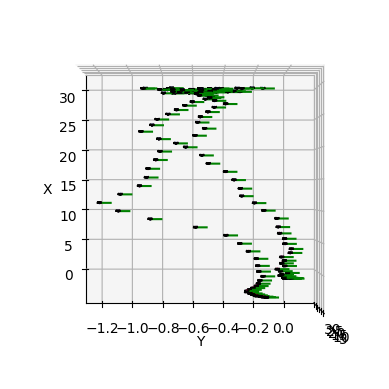

In [ ]:
# camera_poses[0]
i = 0
# R = camera_poses[i][0:3,0:3]
# t=camera_poses[i][0:3, 3]
# w=c[0]
# h=c[1]
# f
# V = R.T @ (V - t.reshape((3, 1)))
# V
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(-90, 0)
for i in range(159):
  plot_camera(camera_poses[i][0:3,0:3], camera_poses[i][0:3,3], c[0], c[1], f)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Triangulation